# 2. Inference with COSDD

In this notebook, we load a trained model and use it to denoise the low signal-to-noise data.

In [15]:
import os
import logging

import tifffile
import torch
import pytorch_lightning as pl
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as PSNR

import utils
from hub import Hub

logger = logging.getLogger('pytorch_lightning')
logger.setLevel(logging.WARNING)
%matplotlib inline

In [2]:
use_cuda = torch.cuda.is_available()

### 2.1. Load test data
The images that we want to denoise are loaded here.

In [6]:
lowsnr_path = "/home/ben/data/convallaria_struc/low_snr.tif"

# load the data
low_snr = tifffile.imread(lowsnr_path).astype(float)
low_snr = torch.from_numpy(low_snr).to(torch.float32)[:, None, :512, :512]
print(f"Noisy data size: {low_snr.size()}")

Noisy data size: torch.Size([100, 1, 512, 512])


As with training, data should be a `torch.Tensor` with dimensions: [Number of images, Channels, Z | Y | X] with data type float32.

### Part 2. Create prediction dataloader

`predict_batch_size` (int): Number of denoised images to produce at a time.

In [7]:
predict_batch_size = 1

predict_set = utils.PredictDataset(low_snr)
predict_loader = torch.utils.data.DataLoader(
    predict_set,
    batch_size=predict_batch_size,
    shuffle=False,
    pin_memory=True,
)

### 2.3. Load trained model

The model we trained in the previous notebook was only trained for 20 minutes. This is long enough to get some denoising results, but a model trained for longer would do better. In the cell below, load the model trained in the previous notebook by recalling the value you gave for `model_name`, or, uncomment line 4 to load a pretrained model that has been trained for x hours.

In [8]:
model_name = "convallaria_struc"
checkpoint_path = os.path.join("checkpoints", model_name)

# checkpoint_path = "pretrained-mito-confocal" ### Once you reach the bottom of the notebook, return here and uncomment this line to see the pretrained model

# hub = Hub.load_from_checkpoint(os.path.join(checkpoint_path, "final_model.ckpt"))
hub = Hub.load_from_checkpoint("checkpoints/convallaria_struc/lightning_logs/version_0/checkpoints/epoch=699-step=126000.ckpt")


trainer = pl.Trainer(
    accelerator="gpu" if use_cuda else "cpu",
    devices=1,
    enable_progress_bar=False,
)

### 2.4. Denoise
In this section, we will look at how COSDD does inference. <br>

The model denoises images randomly, giving us a different output each time. First, we will compare seven randomly sampled denoised images for the same noisy image. Then, we will produce a single consensus estimate by averaging 100 randomly sampled denoised images. Finally, if the direct denoiser was trained in the previous step, we will see how it can be used to estimate this average in a single pass.

### 2.4.1 Random sampling 
First, we will denoise each image seven times and look at the difference between each estimate. The output of the model is stored in the `samples` variable. This has dimensions [Number of images, Sample index, Channels, Z | Y | X] where different denoised samples for the same image are stored along sample index.

In [9]:
use_direct_denoiser = False
n_samples = 7

hub.direct_pred = use_direct_denoiser

samples = []
for _ in tqdm(range(n_samples)):
    out = trainer.predict(hub, predict_loader)
    out = torch.cat(out, dim=0)
    samples.append(out)

samples = torch.stack(samples, dim=1)

  0%|          | 0/7 [00:00<?, ?it/s]/home/ben/miniforge3/envs/COSDD/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=35` in the `DataLoader` to improve performance.
/home/ben/miniforge3/envs/COSDD/lib/python3.12/site-packages/torch/nn/modules/conv.py:453: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608847532/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(F.pad(input, self._reversed_padding_repeated_twice, mode=self.padding_mode),
100%|██████████| 7/7 [01:53<00:00, 16.21s/it]


Here, we'll look at the original noisy image and the seven denoised estimates. Change the value for `img_idx` to look at different images and change values for `top`, `bottom`, `left` and `right` to adjust the crop.

In [10]:
vmin = np.percentile(low_snr.numpy(), 1)
vmax = np.percentile(low_snr.numpy(), 99)

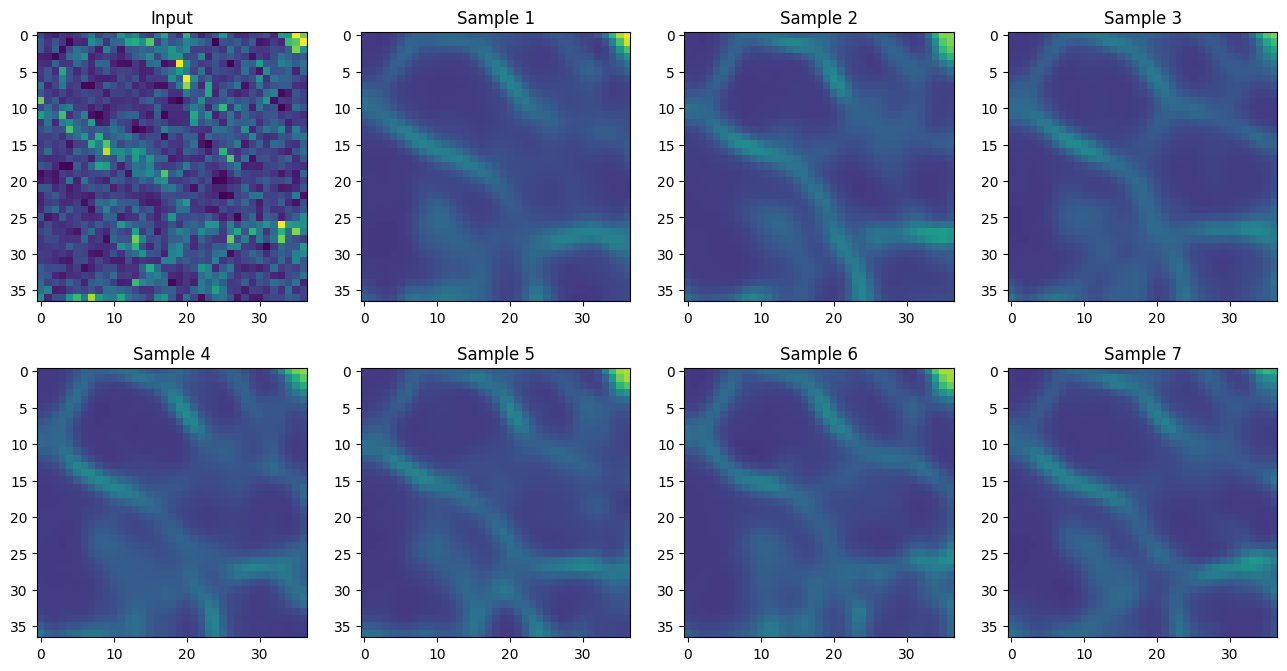

In [12]:
img_idx = 0
top = 475
bottom = 512
left = 475
right = 512

crop = (0, slice(top, bottom), slice(left, right))

fig, ax = plt.subplots(2, 4, figsize=(16, 8))
ax[0, 0].imshow(low_snr[img_idx][crop], vmin=vmin, vmax=vmax)
ax[0, 0].set_title("Input")
for i in range(n_samples):
    ax[(i + 1) // 4, (i + 1) % 4].imshow(
        samples[img_idx][i][crop], vmin=vmin, vmax=vmax
    )
    ax[(i + 1) // 4, (i + 1) % 4].set_title(f"Sample {i+1}")

plt.show()

The six sampled denoised images have subtle differences that express the uncertainty involved in this denoising problem.

### 2.4.2 MMSE estimate

In the next cell, we sample many denoised images and average them for the minimum mean square estimate (MMSE). The averaged images will be stored in the `MMSEs` variable, which has the same dimensions as `low_snr`. 

In [13]:
use_direct_denoiser = False
n_samples = 100  

hub.direct_pred = use_direct_denoiser

samples = []
for _ in tqdm(range(n_samples)):
    out = trainer.predict(hub, predict_loader)
    out = torch.cat(out, dim=0)
    samples.append(out)

samples = torch.stack(samples, dim=1)
MMSEs = torch.mean(samples, dim=1)

100%|██████████| 100/100 [27:43<00:00, 16.64s/it]


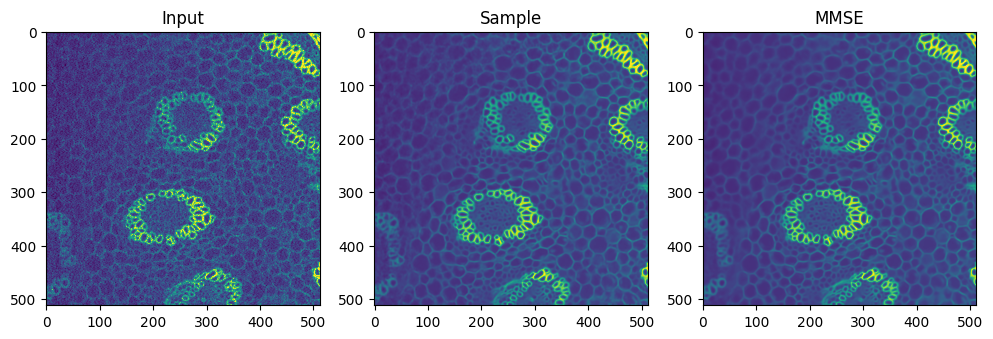

In [14]:
img_idx = 0
top = 0
bottom = 1024
left = 0
right = 1024

crop = (0, slice(top, bottom), slice(left, right))

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(low_snr[img_idx][crop], vmin=vmin, vmax=vmax)
ax[0].set_title("Input")
ax[1].imshow(samples[img_idx][0][crop], vmin=vmin, vmax=vmax)
ax[1].set_title("Sample")
ax[2].imshow(MMSEs[img_idx][crop], vmin=vmin, vmax=vmax)
ax[2].set_title("MMSE")

plt.show()

In [18]:
gt = low_snr.mean(dim=0).numpy()
psnrs = []
data_range = np.max(gt) - np.min(gt)
for i in range(len(MMSEs)):
    test = MMSEs[i].numpy()

    psnrs.append(PSNR(gt, test, data_range=data_range.item()))

print(f"PSNR: {np.mean(psnrs)}")

PSNR: 32.967658326515846


The MMSE will usually be closer to the reference than an individual sample and would score a higher PSNR, although it will also be blurrier.

### 2.4.3 Direct denoising
Sampling 100 images and averaging them is a very time consuming. If the direct denoiser was trained in a previous step, it can be used to directly output what the average denoised image would be for a given noisy image.

In [ ]:
use_direct_denoiser = True
hub.direct_pred = use_direct_denoiser

direct = trainer.predict(hub, predict_loader)
direct = torch.cat(direct, dim=0)

In [ ]:
img_idx = 0
top = 0
bottom = 1024
left = 0
right = 1024

crop = (0, slice(top, bottom), slice(left, right))

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(low_snr[img_idx][crop], vmin=vmin, vmax=vmax)
ax[0].set_title("Input")
ax[1].imshow(direct[img_idx][crop], vmin=vmin, vmax=vmax)
ax[1].set_title("Direct")
ax[2].imshow(MMSEs[img_idx][crop], vmin=vmin, vmax=vmax)
ax[2].set_title("MMSE")

plt.show()

In [ ]:
tifffile.imwrite("MMSE.tif", MMSEs.numpy())
tifffile.imwrite("direct.tif", direct.numpy())
tifffile.imwrite("input.tif", low_snr.numpy())

### 2.5. Incorrect receptive field

We've now trained a model and used it to remove structured noise from our data. Before moving onto the next notebook, we'll look at what happens when a COSDD model is trained without considering the noise structures present. 

COSDD is able to separate imaging noise from clean signal because its autoregressive decoder has a receptive field that spans pixels containing correlated noise, i.e., the row or column of pixels. If its receptive field did not contain pixels with correlated noise, it would not be able to model them and they would be captured by the VAE's latent variables. To demonstrate this, the image below shows a Direct and MMSE estimate of a denoised image where the autoregressive decoder's receptive field was incorrectly set to vertical, leaving it unable to model horizontal noise.

<img src="./resources/no-receptive-field.png">